# TP 2 : Neural Network with one hidden layer

Voici le choix des paramètres pour ce réseau neuronal sans couche cachée:
- Eta : 0.05
- Taille du Mini-batch : 32
- Epoch : 20
- Nombre de neurones dans la couche cachée : 200


Résultats (Précision):
- Sur le jeu de validation : 91.78%
- Sur le jeu de test : 90.96%

Le choix des paramètres aurait pu être amélioré mais par manque de temps, je vous envoie les résultats trouvés.

In [37]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FloatProgress

mnistfile="mnist.pkl.gz"

## If you need to download it : 
#if("mnist.pkl.gz" not in os.listdir(".")):
#    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

In [38]:
import dataset_loader
train_set, valid_set, test_set = dataset_loader.load_mnist(mnistfile)

In [39]:
def init(n_in,n_out):
    W = np.random.normal(0, 1, (n_out, n_in))
    b = np.random.normal(0, 1, (n_out))
    return W,b

def forward(W,b,X):
    """
        Perform the forward propagation
        :param W: the weights (n_output x n_input)
        :param b: the bias (n_output * 1)
        :param X: the input (minibatch_size x n_input)
        :type W: ndarray
        :type B: ndarray
        :type X: ndarray
        :return: the transformed values (n_output x minibatch_size)
        :rtype: ndarray
    """
    b=b.reshape(W.shape[0],1)
    return np.dot(W, X) + b

def softmax(z):
    """
        Perform the softmax transformation to the pre-activation values
        :param a: the pre-activation values (n_output x minibatch_size)
        :type a: ndarray
        :return: the activation values (n_output x minibatch_size)
        :rtype: ndarray
    """
    z = z - np.max(z)
    output = z
    for i_sample in range(z.shape[1]):
        output[:, i_sample] = np.exp(z[:, i_sample]) / np.sum(np.exp(z[:, i_sample]))
    return output

def gradient_out(out, one_hot_batch):
    """
    compute the gradient w.r.t. the pre-activation values of the softmax z_i
    :param out: the softmax values (n_output x minibatch_size)
    :type out: ndarray
    :param one_hot_batch: the one-hot representation of the labels (n_output x minibatch_size)
    :type one_hot_batch: ndarray
    :return: the gradient w.r.t. z (n_output x minibatch_size)
    :rtype: ndarray
    """
    return out - one_hot_batch

def gradient(derror, X):
    """
        Compute the gradient w.r.t. the parameters
        :param derror: the gradient w.r.t. z (n_output x minibatch_size)
        :param X: the input (minibatch_size x n_input)
        :type derror: ndarray
        :type minibatch: ndarray
        :return: the gradient w.r.t. the parameters (n_output x n_input), (n_output, 1)
        :rtype: ndarray, ndarray
    """
    minibatch_size = X.shape[0]
    n_output = derror.shape[0]
    n_input = X.shape[1]
    grad_w = np.zeros((n_output, n_input))
    grad_b = np.zeros(n_output)
    for i_sample in range(minibatch_size):
        grad_b += derror[:, i_sample]
        grad_w += np.outer(derror[:, i_sample], X[i_sample, :])
    
    grad_b /= minibatch_size
    grad_w /= minibatch_size
    return grad_w,grad_b

def update(eta, W, b, grad_w, grad_b):
    """
        Update the parameters with an update rule
        :param eta: the step-size
        :param W: the weights
        :param b: the bias
        :param grad_w: the gradient w.r.t. the weights
        :param grad_b: the gradient w.r.t. the bias
        :type eta: float
        :type W: ndarray
        :type b: ndarray
        :type grad_w: ndarray
        :type grad_b: ndarray
        :return: the updated parameters
        :rtype: ndarray, ndarray
    """
    W = W - eta * grad_w
    b = b - eta * grad_b
    return W, b

In [40]:
def one_hot_transform(labels, n_labels):
    """
    Compute one-hot representation of labels
    :param labels: labels of the samples (1 x minibatch_size)
    :param n_labels: number of different classes
    :type labels: ndarray
    :type n_labels: int
    :type minibatch_size: int
    :return: the one-hot representation (n_labels x minibatch_size)
    :rtype: ndarray
    """
    one_hot_batch=np.zeros((n_labels,len(labels)))
    for pos, label in enumerate(labels):
        one_hot_batch[label,pos]=1
    return one_hot_batch

def log_loss(outputs, one_hot_labels):
    """
    Compute log-loss of current batch
    :param outputs: outputs of the NNet (n_labels x minibatch_size)
    :param one_hot_labels: one-hot representation of real labels (n_labels x minibatch_size)
    :return log-loss summed over all outputs
    """
    return np.sum(-np.log(outputs) * one_hot_labels) / outputs.shape[1]


def accuracy_rate(Y, one_hot_batch):
    """
    Compute classification accuracy of current batch
    :param outputs: outputs of the NNet (n_labels x minibatch_size)
    :param label: labels to predict (n_labels x minibatch_size)
    :return accuracy computed over all outputs
    """
    predicted_one_hot_labels = np.zeros(one_hot_batch.shape)
    for pos,predicted_label in enumerate(np.argmax(Y,axis=0)):
        predicted_one_hot_labels[predicted_label,pos]=1

    nb_correct_predictions = np.sum(predicted_one_hot_labels * one_hot_batch)
    return nb_correct_predictions/one_hot_batch.shape[1]

In [41]:
def train_hidden(n_in, n_h, n_out, eta, epochs, minibatch_size, train_set):
    
    #paramètres initialisation + historique
    tot_train=train_set[0].shape[0]
    
    train_loss=[]
    train_accuracy=[]
    valid_loss=[]
    valid_accuracy=[]
    
    W1,b1=init(n_in,n_h)
    W2,b2=init(n_h,n_out)
    
    nb_batch=tot_train//minibatch_size
    f = FloatProgress(min=0, max=nb_batch)
    
    for e in range(epochs):
        print("Training model (epoch = {}/{})".format(e+1, epochs))
        f = FloatProgress(min=0, max=nb_batch)
        display(f)
        for n in range(nb_batch):
            f.value+=1
            #lecture du minibatch
            batch=train_set[0][(n*minibatch_size):((n+1)*minibatch_size)]
            labels=train_set[1][(n*minibatch_size):((n+1)*minibatch_size)]
            X=batch
            
            # representation one-hot des labels à prédire
            labels_to_predict=one_hot_transform(labels,n_out)
            
            #forward propagation
            #1st layer + activation
            h=np.tanh(forward(W1,b1,np.transpose(X)))
            #2nd layer + activation
            Y=forward(W2,b2,h)
            outputs=softmax(Y)
            # calcul de la log-loss et de la précision pour ce batch
            train_loss.append(log_loss(outputs,labels_to_predict))
            train_accuracy.append(accuracy_rate(outputs,labels_to_predict))
            
            if valid_set:
                h_valid = np.tanh(forward(W1, b1, np.transpose(valid_set[0])))
                outputs_valid = softmax(forward(W2, b2, h_valid))
                labels_valid = one_hot_transform(valid_set[1], n_out)
                valid_loss.append(log_loss(outputs_valid, labels_valid))
                valid_accuracy.append(accuracy_rate(outputs_valid, labels_valid))
            
            
            # calcul du gradient de sortie : backward propagation
            out=gradient_out(outputs, labels_to_predict)
            grad_W2, grad_b2 = gradient(out,np.transpose(h))
            derrorh=np.dot(np.transpose(W2),out)
            grad_W1, grad_b1 = gradient(derrorh,X)
            
            #update du modèle
            W2,b2=update(eta, W2, b2, grad_W2, grad_b2)
            W1,b1=update(eta, W1, b1, grad_W1, grad_b1)
            
    return(W2,b2,W1,b1,train_loss,train_accuracy,valid_loss,valid_accuracy)

# TRAIN

In [42]:
#PARAMETERS
N_IN=784
N_H=200
N_OUT=10
ETA=0.05
EPOCHS=20
MINIBATCH_SIZE=32

In [43]:
#Train
W2,b2,W1,b1,train_loss,train_accuracy,valid_loss,valid_accuracy=train_hidden(N_IN, N_H, N_OUT, ETA, EPOCHS, MINIBATCH_SIZE, train_set)

Training model (epoch = 1/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 2/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 3/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 4/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 5/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 6/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 7/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 8/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 9/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 10/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 11/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 12/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 13/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 14/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 15/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 16/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 17/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 18/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 19/20)


FloatProgress(value=0.0, max=1562.0)

Training model (epoch = 20/20)


FloatProgress(value=0.0, max=1562.0)

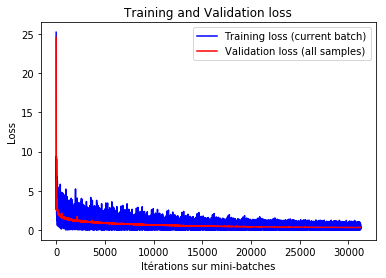

validation loss:0.3132040234264709


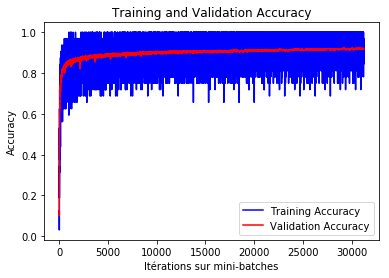

validation accuracy:0.9178


In [44]:
plt.plot(train_loss, "b", label='Training loss (current batch)')
plt.plot(valid_loss, "r", label='Validation loss (all samples)')
plt.title("Training and Validation loss")
plt.xlabel("Itérations sur mini-batches")
plt.ylabel("Loss")
plt.legend()
plt.show()
print('validation loss:{}'.format(valid_loss[len(valid_loss)-1]))

plt.plot(train_accuracy, "b", label='Training Accuracy')
plt.plot(valid_accuracy, "r", label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Itérations sur mini-batches")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
print('validation accuracy:{}'.format(valid_accuracy[len(valid_accuracy)-1]))

# TEST

In [45]:
#TEST
h_valid = np.tanh(forward(W1, b1, np.transpose(test_set[0])))
outputs_test = softmax(forward(W2, b2, h_valid))
labels_test = one_hot_transform(test_set[1], 10)
print("Results for test set :")
print(" - log loss moyenne = {:.3f}".format(log_loss(outputs_test, labels_test)))
print(" - taux de précision = {:.2f}%".format(100*accuracy_rate(outputs_test, labels_test)))

Results for test set :
 - log loss moyenne = 0.345
 - taux de précision = 90.96%
